This will have the same content as the single-run kmeans file but in a jupyter notebook format it'll be easier to run and manage 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import csv
import pandas as pd  
from scipy import stats as st
from sklearn.preprocessing import MinMaxScaler
from collections import Counter 

events = 10 
density = '1' 
noise = 0 
filename = None 
folder = None 
k = 100
max_iters = 500

In [2]:
def kmeans_gpu(data, k, max_iters=100):
    data = data.to(device)
    centroids = data[torch.randperm(len(data))[:k]]

    for i in range(max_iters):
        #print(f"Iteration: {i+1}")
        dist = torch.cdist(data, centroids) 
        ai_labels = torch.argmin(dist, dim=1)

        # update centroids 
        for j in range(k):
            centroids[j] = data[ai_labels == j].mean(dim=0)
    
    return ai_labels.cpu().numpy(), centroids.numpy()

device = "cuda" if torch.cuda.is_available() else "cpu" 

In [3]:
def labelmaker(events=None, sp_density=None, t_density=None, noise=None, filename = None, folder = None): 
    '''creates labels based on my naming convention for different files, keeps it consistent and easy'''
    if folder: 
        folder = folder + '/'

    if filename: 
        datafile = str(filename) 
    else: 
        datafile = str(events) + 'ev_' + str(sp_density) + 'spd_' + str(t_density) + 'td_n' + str(noise)
    

    labelfile = 'labels_' + datafile + '.csv'
    sourcefile = 'sources_' + datafile + '.csv'
    ai_labelfile = datafile + '_results' + '.csv'
    centroidfile = datafile + '_centroids' + '.csv'
    datafile = datafile + '.csv'

    if folder: 
        datafile = folder + datafile 
        centroidfile = folder + centroidfile 
        ai_labelfile = folder + ai_labelfile 
        labelfile = folder + labelfile 
        sourcefile = folder + sourcefile 

    
    return datafile, labelfile, sourcefile, ai_labelfile, centroidfile

def readfiles(datafile, labelfile, sourcefile): 
    '''data reader and simplifier for files that haven't been passed through the algorithm'''
    columns = ['x[px]', 'y[px]', 't[s]']
    
    dataread = pd.read_csv(datafile) 
    data = np.array(dataread[columns])
    
    labelread = pd.read_csv(labelfile)
    labels = np.array(labelread['labels'])

    sourceread = pd.read_csv(sourcefile) 
    sources = np.array(sourceread[columns])

    return data, labels, sources

def readai(datafile, labelfile, sourcefile, ai_labelfile, centroidfile):
    '''file reader and data simplifier for data thats been through the algorithm'''
    columns = ['x[px]', 'y[px]', 't[s]']
    
    dataread = pd.read_csv(datafile) 
    data = np.array(dataread[columns])
    
    labelread = pd.read_csv(labelfile)
    labels = np.array(labelread['labels'])

    sourceread = pd.read_csv(sourcefile) 
    sources = np.array(sourceread[columns])

    ai_labelsread = pd.read_csv(ai_labelfile)
    ai_labels = np.array(ai_labelsread['labels'])

    centroidread = pd.read_csv(centroidfile) 
    centroids = np.array(centroidread[columns])

    return data, labels, sources, ai_labels, centroids

Generating datafile names and data + normalizing it using MinMaxScaling below: 

In [5]:
# datafile, labelfile, sourcefile, ai_labelfile, centroidfile = labelmaker(events, density, noise, filename, folder)
# # read out the files
# data, labels, sources = readfiles(datafile, labelfile, sourcefile)
# # establish feature range and transform data, can comment this out to turn off scaling, naming is the same
# scaler = MinMaxScaler(feature_range=(0,1))
# # scale coordinate data 
# data = scaler.fit_transform(data)
# sources = scaler.fit_transform(sources)
# # turn data into a tensor 
# data_tensor = torch.Tensor(data)

Running k-means algorithm

In [6]:
# ai_labels, centroids = kmeans_gpu(data_tensor, k, max_iters)

Writing to the centroid and ai_label files 

In [7]:
# with open(ai_labelfile, mode = 'w', newline='') as wfile: 
#     writer = csv.writer(wfile)
#     writer.writerow(['labels'])
#     for item in ai_labels: 
#                 writer.writerow([item])

# columns = ['x[px]', 'y[px]', 't[s]']
# with open(centroidfile, mode = 'w', newline = '') as wfile: 
#     writer = csv.writer(wfile)
#     writer.writerow(columns)
#     writer.writerows(centroids)

In [15]:
# reading out ai generated files after the algorithm run 

data, labels, sources, ai_labels, centroids = readai(datafile, labelfile, sourcefile, ai_labelfile, centroidfile)

Breaks and sizing functions for the true label-focused loss function 

In [8]:
def breaks(array): 
    '''This function takes an array, goes through it item by item, and returns the list of indices where the value changes'''
    value = array[0] 
    indices = []
    for index, ele in enumerate(array): 
        if ele != value:
            indices.append(index)
            value = array[index]
    indices.append(len(array))

    return indices

def sizes(indices): 
    '''This function takes a list of indices and calculates the number of items belonging to each value by taking the difference between 
    subsequent indices'''
    gaps = []
    prev=0
    for i in range(len(indices)):
        gaps.append(indices[i]-prev)
        prev = indices[i]

    return gaps

True Label-Focused Loss, ripped from the losses file 

In [9]:
# additional function needed for the loss function 
def modded_mode(array): 
    '''This function will return event labels, its a modification on a normal mode function where the label has to appear at least 33% of the time to be a label in that chunk.'''
    n = len(array)
    if n == 0: 
        return []
    
    threshold = n/3 
    counts = Counter(array)

    result = [key for key, count in counts.items() if count >= threshold]
    return result 

# THE loss func. 

def truth_based_loss(true_labels, ai_labels):
    # labels are already sorted by true labels predictions 

    # getting break indices and cluster sizes 
    break_indices = breaks(true_labels)
    gaps = sizes(break_indices)
    n_events = len(gaps)

    # initialize variables 
    counter = Counter()
    fractions_misIDs = []
    total_splits, ev_per_split = 0,0 
    total_splits = 0 
    total_misIDs = 0 


    # process each chunk that's separated by truth gaps 
    for start, end, gap in zip([0] + break_indices[:-1], break_indices, gaps):
        chunk = ai_labels[start:end]
        chunk_modes = modded_mode(chunk)

        # update counter
        counter.update(chunk_modes)
    
        e_in_split = len(chunk_modes) # number of ai events found in the chunk
        if e_in_split > 1: 
            total_splits += 1
            ev_per_split += e_in_split # if there is more than one, increase splits and events in split 
        
        misIDs = sum(1 for item in chunk if item not in chunk_modes)
        total_misIDs += misIDs
        fractions_misIDs.append(misIDs/gap)
    
    # Combination Statistics 
    repeat_labels = {k: v for k, v in counter.items() if v>1}
    total_combos = len(repeat_labels) # the amount of combinations is the same as the amount of labels that get repeated through the set 
    ev_per_combo = sum(repeat_labels.values())/total_combos if total_combos else 0 # sum all repeats together and average over number of combinations 
    frac_combos = total_combos / n_events # fraction of events experiencing combination
    
    # other stats 
    ev_per_split = ev_per_split/total_splits if total_splits else 0
    frac_splits = total_splits/n_events
    avg_misIDs = np.mean(fractions_misIDs)

    # output da resultssss
    # print(f"The fraction of splits over all events is {frac_splits}")
    # print(f"The average number of events involved in a single split is {ev_per_split}")
    # print(f"The fraction of combinations over all events is {frac_combos}")
    # print(f"The average number of events involved in a single combo is {ev_per_combo}")
    # print(f"The average fraction of photons misidentified in each event is {avg_misIDs}")

    return frac_splits, ev_per_split, frac_combos, ev_per_combo, avg_misIDs

AI Label-Focused Loss function

In [10]:
# these results should match up exactly with the previous loss function within rounding errors 

import numpy as np
from collections import Counter

def ai_based_loss(true_labels, network_labels):
    """
    More efficient implementation of the AI-based loss function.
    This function clusters AI labels and calculates relevant loss statistics.
    """
    
    # Sort labels based on AI predictions
    sorted_pairs = sorted(zip(network_labels, true_labels))
    reo_network_labels, reo_true_labels = zip(*sorted_pairs)

    # Get break indices and cluster sizes
    break_indices = breaks(reo_network_labels)
    gaps = sizes(break_indices)
    # n_events = len(gaps)

    # Initialize variables
    counter = Counter()
    fractions_misIDs = []
    total_combos, ev_per_combo = 0, 0
    total_splits = 0
    total_misIDs = 0 

    # Process each AI-clustered chunk
    for start, end, gap in zip([0] + break_indices[:-1], break_indices, gaps):
        chunk = reo_true_labels[start:end]
        chunk_modes = modded_mode(chunk)  # Get dominant modes (max 3)
        
        # Update Counter directly  
        counter.update(chunk_modes)

        e_in_combo = len(chunk_modes)
        if e_in_combo > 1:
            total_combos += 1
            ev_per_combo += e_in_combo
        
        misIDs = sum(1 for item in chunk if item not in chunk_modes)
        total_misIDs += misIDs
        fractions_misIDs.append(misIDs / gap)
    
    n_events = len(counter)
    # Compute split statistics
    repeat_labels = {k: v for k, v in counter.items() if v > 1}
    total_splits = len(repeat_labels)
    ev_per_split = sum(repeat_labels.values()) / total_splits if total_splits else 0
    frac_splits = total_splits / n_events

    # Compute final metrics
    ev_per_combo = ev_per_combo / total_combos if total_combos else 0
    frac_combos = total_combos / n_events
    avg_misIDs = np.mean(fractions_misIDs)


    # Output results
    print(f"The fraction of splits over all events is {frac_splits}")
    print(f"The average number of events involved in a single split is {ev_per_split}")
    print(f"The fraction of combinations over all events is {frac_combos}")
    print(f"The average number of events involved in a single combo is {ev_per_combo}")
    print(f"The average fraction of photons misidentified in each event is {avg_misIDs}")

    return frac_splits, ev_per_split, frac_combos, ev_per_combo, avg_misIDs




In [21]:
# testing to compare ai and truth based loss functions 
print("---- TRUTH BASED LOSS: ----")
truth_based_loss(labels, ai_labels)
print("---- AI BASED LOSS: ----")
ai_based_loss(labels, ai_labels)



---- TRUTH BASED LOSS: ----
The fraction of splits over all events is 0.0
The average number of events involved in a single split is 0
The fraction of combinations over all events is 0.0
The average number of events involved in a single combo is 0
The average number of photons misidentified in each event is 0.9208333333333334
---- AI BASED LOSS: ----
The fraction of splits over all events is 0.1
The average number of events involved in a single split is 10.3
The fraction of combinations over all events is 0.03
The average number of events involved in a single combo is 2.0
The average number of photons misidentified in each event is 0.009357142857142857


(0.1, 10.3, 0.03, 2.0, 0.009357142857142857)

In [32]:
# test dataset for loss function testing 

true_labelz = np.array([1,1,1,1,2,2,3,3,3,3,3,3])
ai_labelz = np.array([8,55,55,55,55,55,101,101,8,8,55,8])

truth_based_loss(true_labelz, ai_labelz)
print("----")
ai_based_loss(true_labelz, ai_labelz)

# (8, 8, 8, 8, 55, 55, 55, 55, 55, 55, 101, 101)
# (1, 3, 3, 3, 1, 1, 1, 2, 2, 3, 3, 3)

The fraction of splits over all events is 0.3333333333333333
The average number of events involved in a single split is 2.0
The fraction of combinations over all events is 0.3333333333333333
The average number of events involved in a single combo is 2.0
The average number of photons misidentified in each event is 0.13888888888888887
----
The fraction of splits over all events is 0.3333333333333333
The average number of events involved in a single split is 2.0
The fraction of combinations over all events is 0.3333333333333333
The average number of events involved in a single combo is 2.0
The average number of photons misidentified in each event is 0.13888888888888887


(0.3333333333333333, 2.0, 0.3333333333333333, 2.0, 0.13888888888888887)

In [ ]:
# ELBOW METHOD 

def elbowmeth(int_range, datafile, folder, iterations, pltfile, pltnum, weighted = True):
    '''will perform the elbow method on a given dataset for a given range of k integers and return the k value with the lowest loss, as well as the value of that loss
    and a plot demonstrating the loss'''
    datafile, labelfile, sourcefile, ai_labelfile, centroidfile = labelmaker(filename = datafile, folder = folder)
    data, labels, sources = readfiles(datafile, labelfile, sourcefile)
    scaler = MinMaxScaler(feature_range=(0,1))
    # scale coordinate data 
    data = scaler.fit_transform(data)
    sources = scaler.fit_transform(sources)
    # turn data into a tensor 
    data_tensor = torch.Tensor(data)
    total_losses = []    

    coeff = [1,1,1]

    for kval in int_range: 
        ai_labels, centroids = kmeans_gpu(data_tensor, k=kval, max_iters=iterations)
        frac_splits, ev_per_split, frac_combos, ev_per_combo, avg_misIDs = truth_based_loss(true_labels = labels, ai_labels=ai_labels)
        if weighted: 
            coeff = [1,2,3]
        total_loss = np.dot(coeff, [avg_misIDs, frac_splits, frac_combos])
        total_losses.append(total_loss)

    if pltnum%5 == 0:
        #generate plot for every fifth iteration
        plt.figure()
        plt.plot(int_range, total_losses)
        plt.xlabel("K values")
        plt.ylabel("Total loss")
        plt.title(f"Elbow method for k = {int_range} for {datafile} {pltnum}")
        plt.tight_layout()
        plt.savefig(pltfile)   
        print(f"{pltnum}% complete!")     

    min_loss = np.min(total_losses)
    min_k = int_range[total_losses.index(min_loss)]

    print(f"The minimum loss is {min_loss} with a k value of {min_k}")
    return min_loss, min_k


In [17]:
from segmentation_sim import new_parallel_sim # this only works if parsed arguments in segmentation_sim.py are commented out!

0.010.010.010.010.01

0.2053388090349076

0.2053388090349076


0.2053388090349076

0.20533880903490760.2053388090349076


0.010.01

0.2053388090349076
0.20533880903490760.01
0.010.01


0.20533880903490760.2053388090349076
0.2053388090349076

0.010.010.01


0.20533880903490760.010.20533880903490760.010.2053388090349076




0.20533880903490760.2053388090349076

0.01
0.010.20533880903490760.01


0.20533880903490760.010.01
0.2053388090349076
0.2053388090349076


0.2053388090349076
0.01
0.010.20533880903490760.01
0.01

0.010.2053388090349076
0.2053388090349076


0.20533880903490760.2053388090349076

0.010.01
0.20533880903490760.010.01

0.01
0.2053388090349076
0.2053388090349076

0.2053388090349076
0.2053388090349076

0.010.010.010.01
0.2053388090349076
0.2053388090349076



0.010.20533880903490760.2053388090349076


0.2053388090349076
0.010.010.010.010.01




0.20533880903490760.20533880903490760.20533880903490760.20533880903490760.2053388090349076




0.010.01

0.20533880903490760.01
0.20533880903490760.010.01


0.2053388090349076

0.20533880903490760

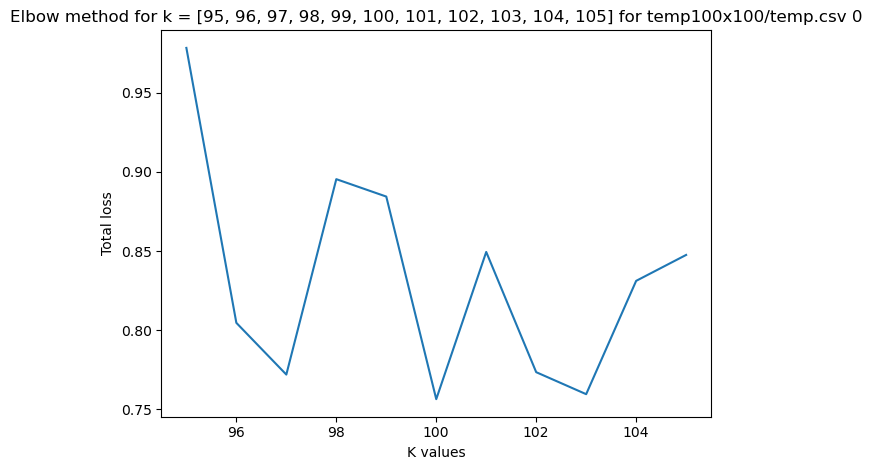

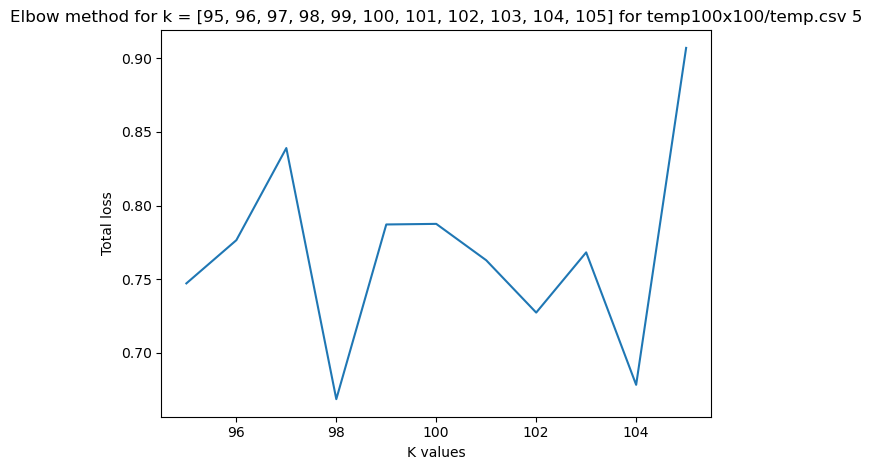

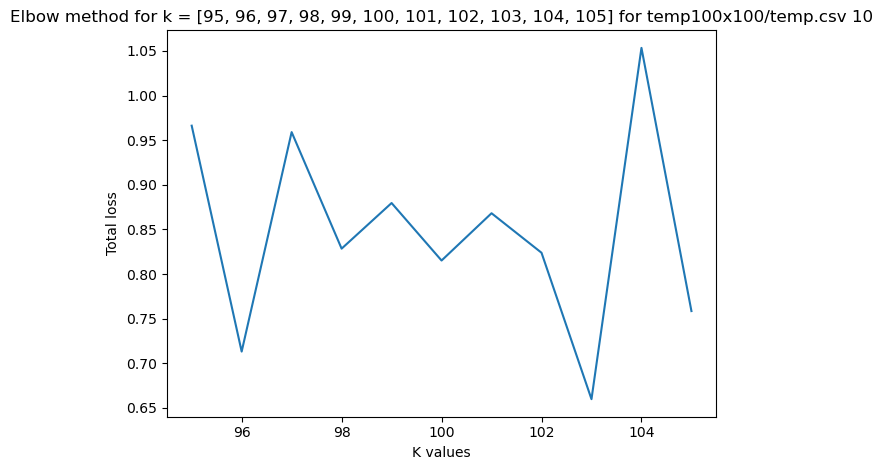

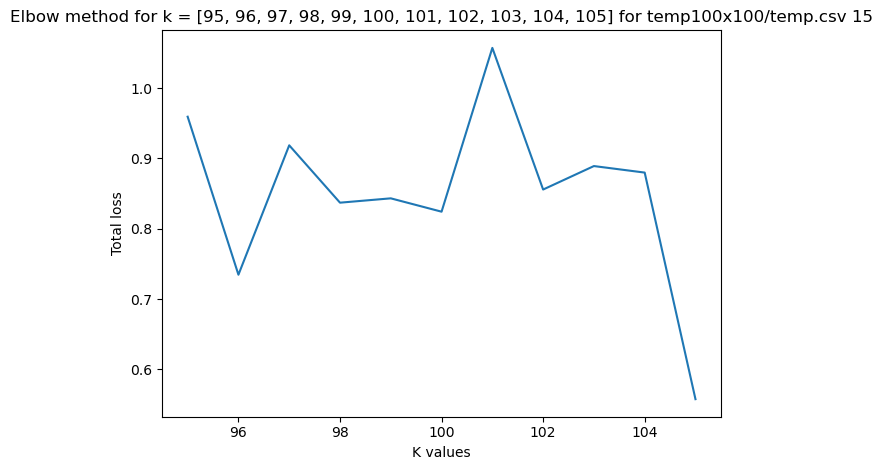

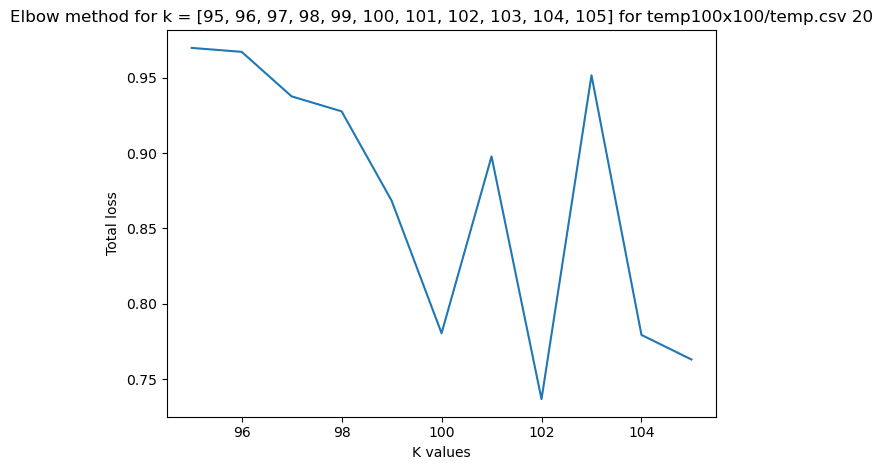

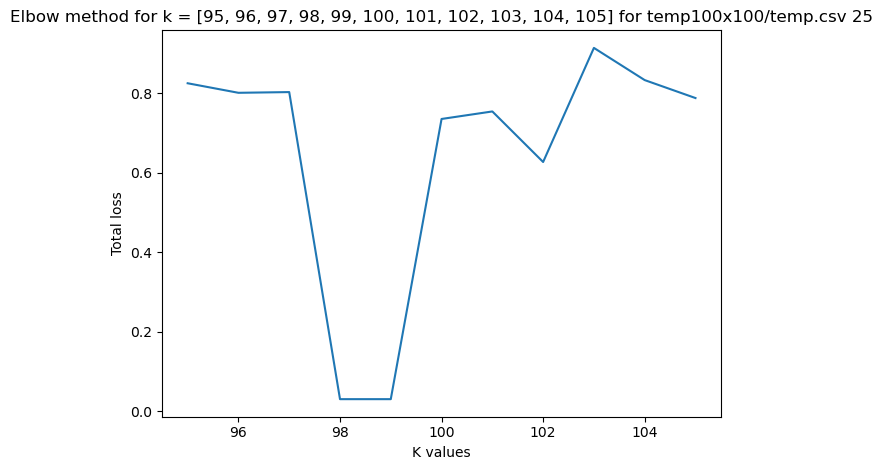

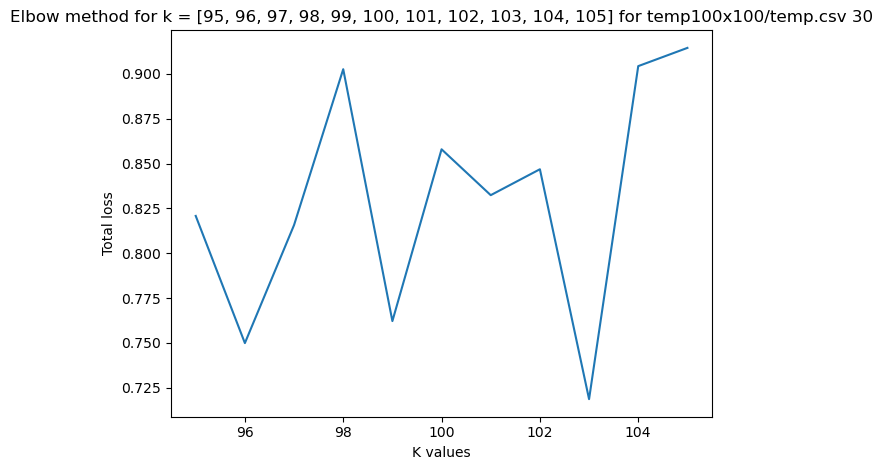

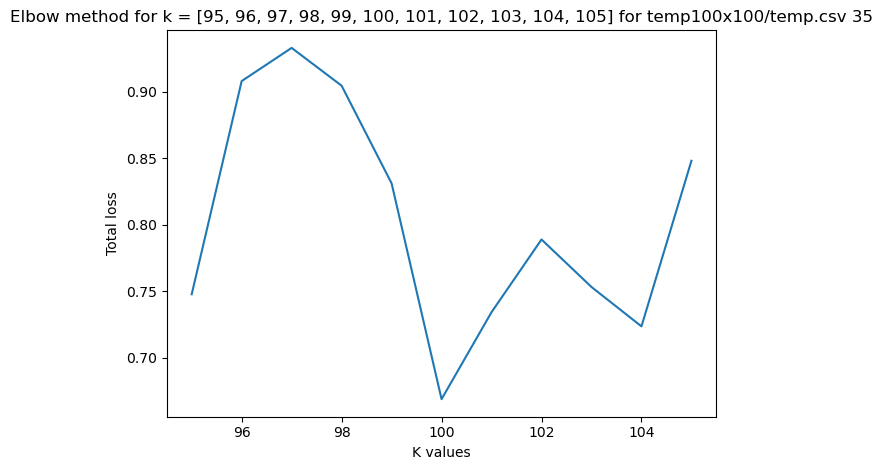

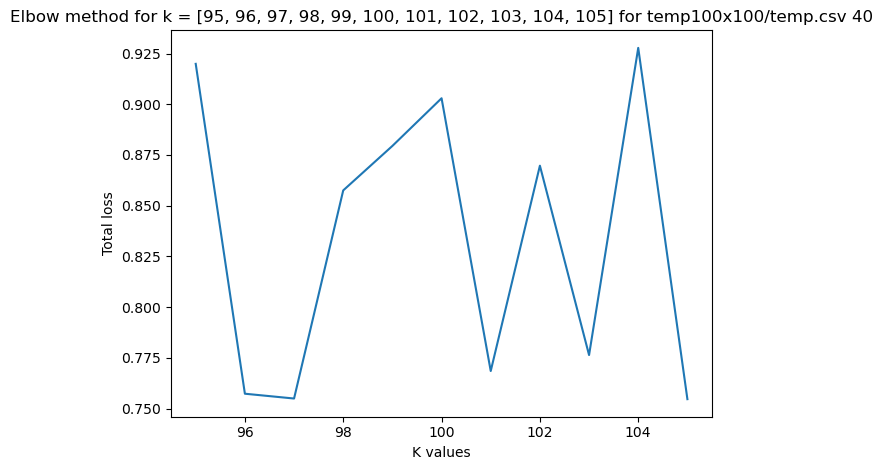

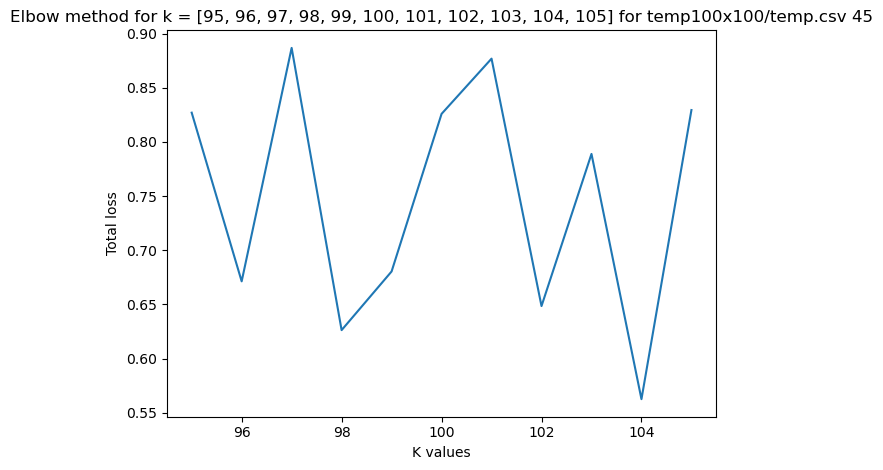

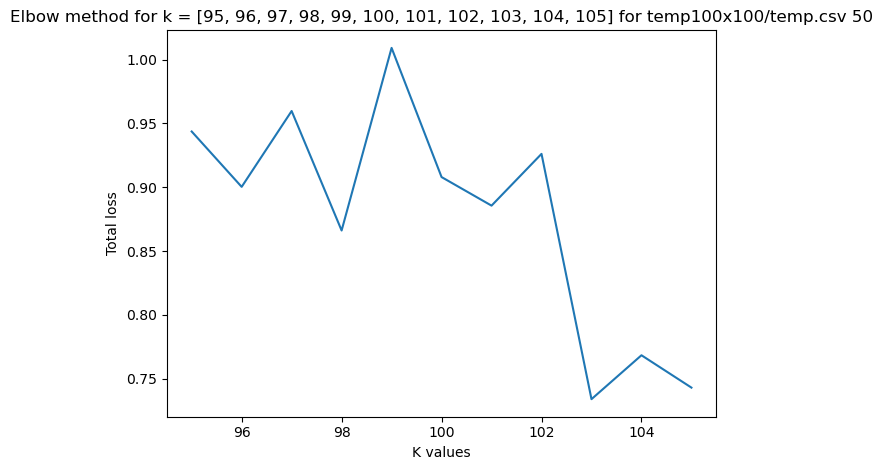

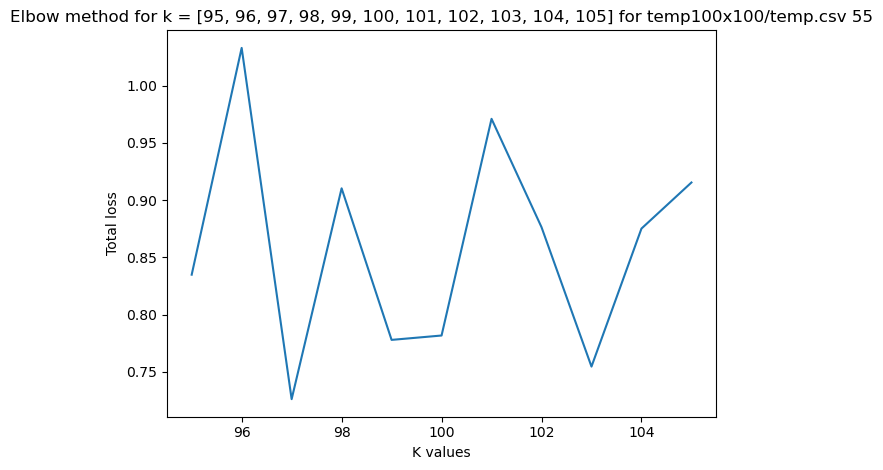

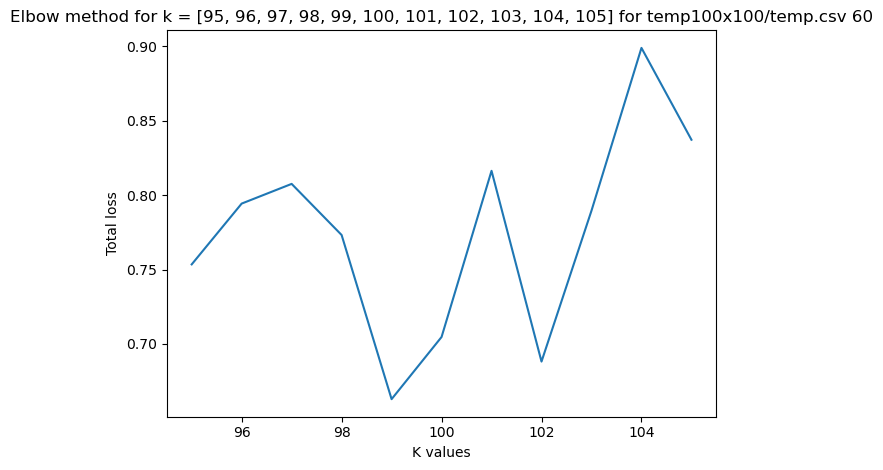

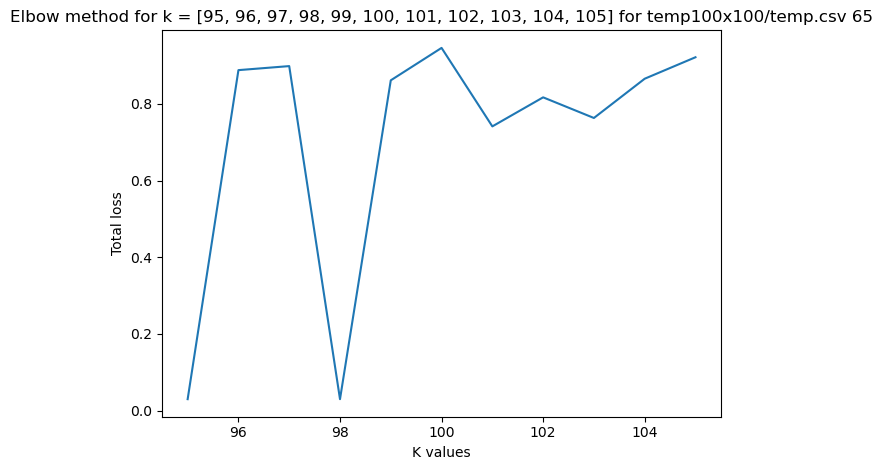

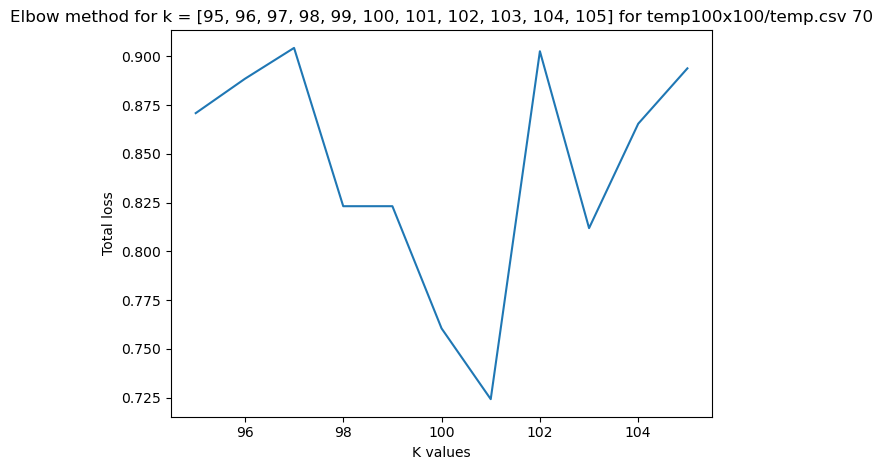

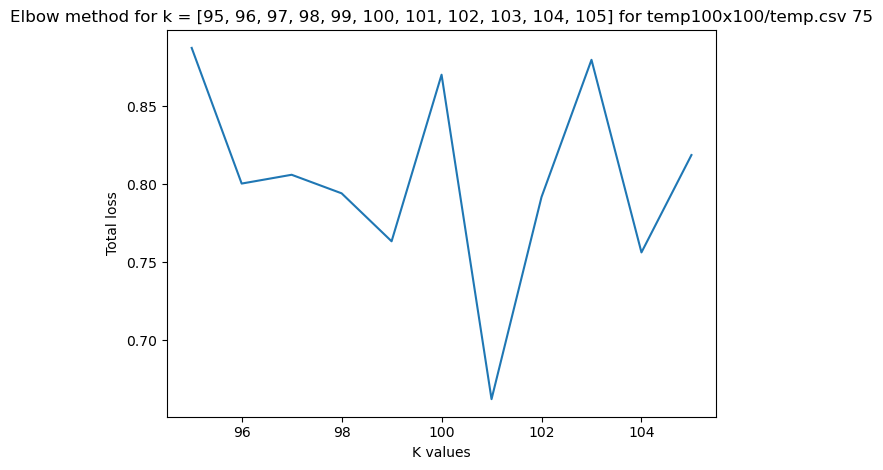

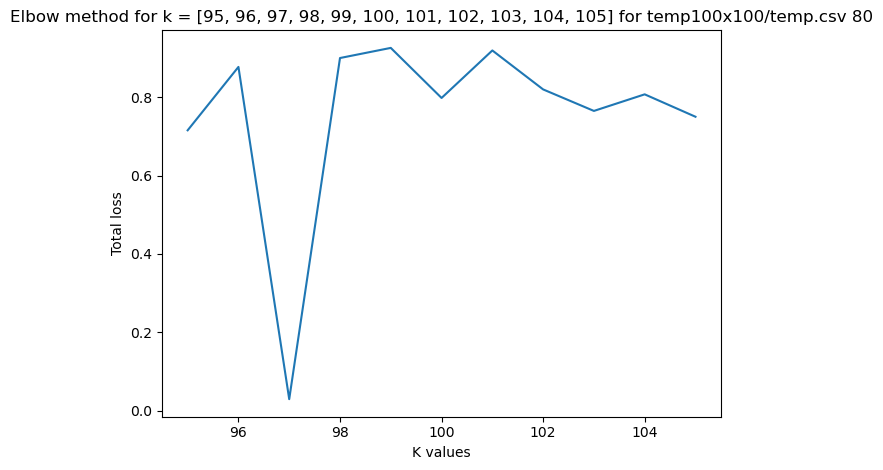

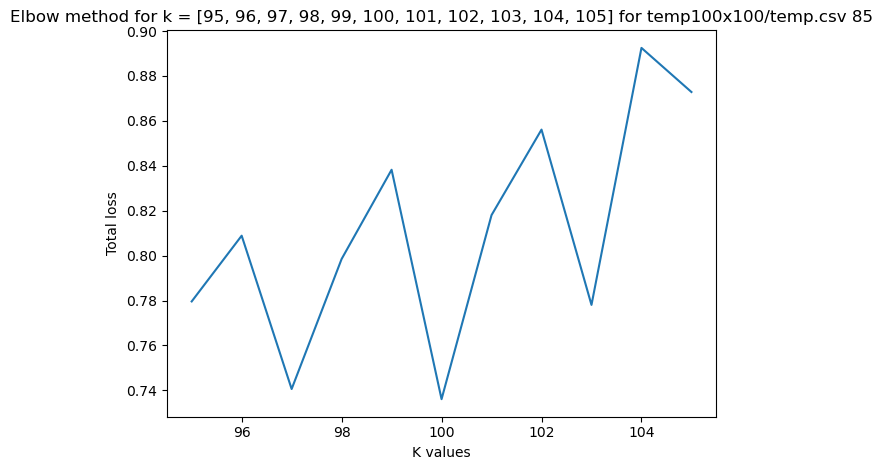

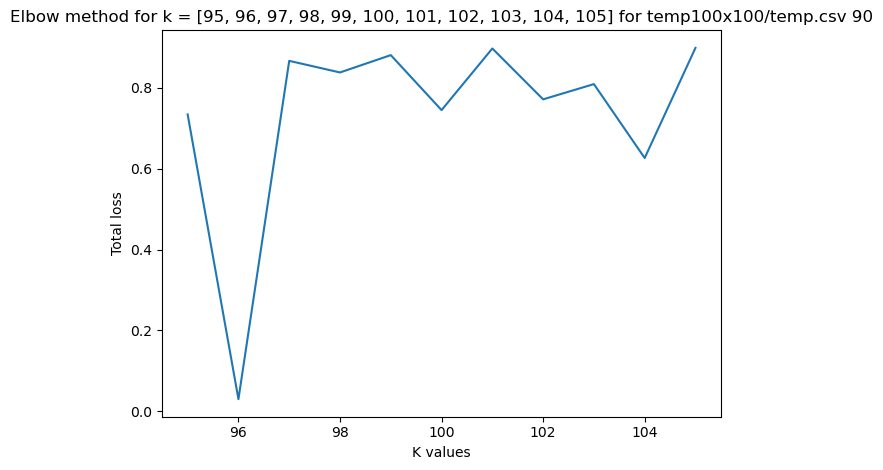

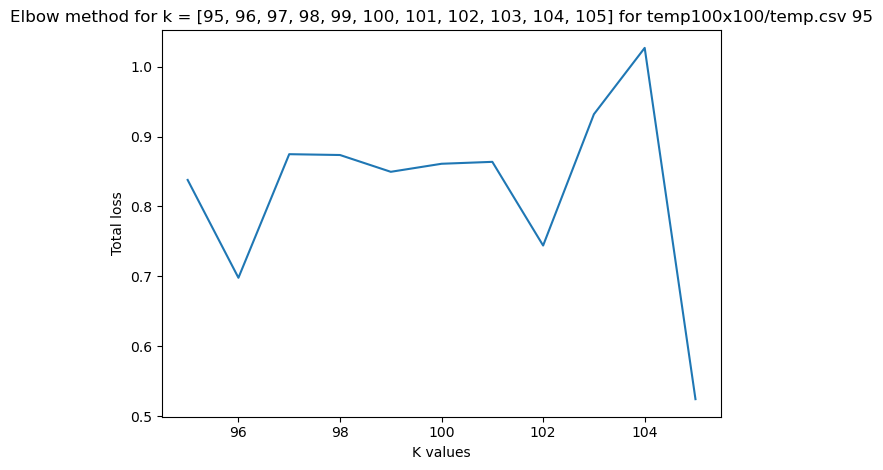

In [18]:
# big algo 

k_range = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]

bigLossFile = 'temp100x100/loss_totals.csv'
columns = ['lowest kval', 'min loss']
with open(bigLossFile, mode = 'w', newline = '') as wfile: 
    writer = csv.writer(wfile)
    writer.writerow(columns) # write the columns into the loss file to begin with 

for i in range(100): # 100 iterations to get good statistics 
    new_parallel_sim(100, 0, 5, folder = 'temp100x100', dataSaveID = 'temp') # generate data of 100 events, no noise, full density, using 5 cores for speed 
    min_loss, min_k = elbowmeth(k_range, datafile = 'temp', folder = 'temp100x100', iterations = 100, pltfile = f'temp100x100/kvals_losses_{i}.png', pltnum = i) # run elbow meth!
    with open(bigLossFile, mode = 'w', newline = '') as wfile: # write in the best loss and best kval 
        writer = csv.writer(wfile)
        writer.writerow([min_k, min_loss])